<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [100]:
%%capture
pip install pyswarms

In [101]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [102]:
MAX_VALUE_CUSTO = 1000000
fator_melhoria = 'expo'

In [103]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [104]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [105]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [106]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [107]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [108]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [109]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [110]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [136]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [137]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


In [192]:
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.25, 3:0.50, 5:0.75, 7:1.0}

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cálculo da intensidade de falha
    # Cria as variaveis
    # tempos de falhas
    t = df['t']
    # indice do sistema
    k = df['k']
    m = k.drop_duplicates().shape[0]
    # Numero de ciclos de manutenção
    ck = df['c'].max()
    # Numero de falhas e severidade das manutenções preventivas em cada sistema
    n = []
    s = []

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s.append(list(df['s'][k * ck:(k + 1) * ck]))

    # Tempos das MP
    T = list(df['T'][:m])

        # Obter o número de ciclos de manutenção
    num_ciclos = ck

    # Obter os tempos para manutenções preventivas
    tempos_mp = T

    # Cria alguns cenários de teste
    beta = 5

    solucao = [lamb, beta, theta]

    # Cria a instância da classe IntensidadeFalha
    falha = IntensidadeFalha()

    # Inicializa a instância com os valores necessários
    falha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

    # Cria os dados da intensidade de falha
    falha.create()

    # Cálculo do custo total
    custo_total = 0
    for k in range(m):
        for i in range(num_ciclos):
            if s[k][i] in dict_severidades:
                severidade = dict_severidades[s[k][i]]
                custo_total += custo_mp([severidade], CMP) + (CMC * (1 - np.exp(-lamb * beta * severidade * ck * tempos_mp[k])))

    custo_total = min(custo_total, MAX_VALUE_CUSTO)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir a severidade para cada ciclo de manutenção
    for k in range(m):
        print("")
        print("=========================================================================")
        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])


    return custo_total

In [202]:
num_particles = 30
max_iterations = 10
dimensions = 30
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Lista para armazenar o custo em cada iteração
cost_history = []

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)
    cost_history.append(best_cost)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-03 03:33:51,168 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  40%|████      |4/10, best_cost=0

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|10/10, best_cost=0
2023-07-03 03:33:51,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.23089084 0.71484046 0.56073337 0.65114139 0.41646545 0.92250126
 0.52549816 0.54580889 0.36640985 0.3367795  0.79029466 0.20732431
 0.00526413 0.07153037 0.74048815 0.75046428 0.3744307  0.93657623
 0.98829796 0.69218667 0.59741482 0.11596324 0.95197631 0.03513298
 0.61686754 0.70102818 0.44696766 0.29730301 0.23849662 0.11231244]
2023-07-03 03:33:51,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manut

pyswarms.single.global_best:   0%|          |0/1

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:51,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 0.23213237  0.79231831  0.7004684   0.68818063  0.45184644  0.33365287
  0.54330869  1.06896605  0.5201011   0.0040874   0.93703133  0.78202805
  0.00579204 -0.01985091  1.29102215  0.87748595  0.39365463  0.29775924
  1.49360291  0.57607026  0.64491559 -0.04479232  1.51597378  0.36771299
  0.69098462  0.70957391  0.52644453  0.01763312  0.23223795  0.22242117]
2023-07-03 03:33:51,700 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:51,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.24163477 1.07120685 1.17500168 0.71488306 0.50970767 0.90547302
 0.60561842 1.45187035 0.73006334 0.52331719 1.28885023 1.32018059
 0.00671808 0.01190893 1.68407449 0.94004343 0.43663298 0.86056528
 1.76387972 0.86725421 0.7480703  0.63547147 1.67064926 0.84818574
 0.7467076  0.73046013 0.59225188 0.16642261 0.32926056 0.30113341]
2023-07-03 03:33:51,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:51,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.24763058 1.24055042 1.53635954 0.73374228 0.55738905 1.4223687
 0.64841763 1.71879786 0.84590311 0.95883639 1.50351149 1.76732413
 0.00734299 0.0550572  1.80346861 0.98348773 0.45890466 1.37838351
 1.89241901 1.11117678 0.80759628 1.09255482 1.78289897 1.07704448
 0.77597351 0.742063   0.6320394  0.3153306  0.4153952  0.354242  ]
2023-07-03 03:33:51,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   0%|          |0/1

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:51,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.2509848  1.27599901 1.72072597 0.74158554 0.57463135 1.85054725
 0.66786242 1.73389733 0.84478539 1.31245596 1.59256141 2.14981209
 0.00788984 0.09622496 1.65932839 0.96432248 0.45885299 1.76475487
 1.82039814 1.32304395 0.82425208 1.41777789 1.7165338  1.09699475
 0.78811872 0.74353371 0.6509496  0.44868119 0.46190815 0.3820012 ]
2023-07-03 03:33:51,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1, best_cost=0

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:51,986 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.25005409 1.15869071 1.62177616 0.73065606 0.58891715 1.96539699
 0.67007782 1.532824   0.84011697 1.52641386 1.46427201 2.01610108
 0.00797506 0.12609509 1.47808691 0.91886059 0.44789775 1.91745886
 1.53029436 1.45650376 0.8342188  1.4711836  1.47596546 0.84737014
 0.78522232 0.74303703 0.65852092 0.53944577 0.4975614  0.3540855 ]
2023-07-03 03:33:51,991 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:52,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.2487439  0.94438397 1.46358117 0.71799158 0.5644565  1.91687453
 0.6321992  1.29592771 0.79815982 1.5930985  1.29352674 1.80987064
 0.00787456 0.14572069 1.25433421 0.83056173 0.42952998 1.

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:   0%|          |0/1

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:52,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.2428285  0.72284522 1.14146057 0.69418365 0.51448449 1.83711112
 0.58018764 0.88976311 0.6927636  1.49205108 1.04430383 1.28303416
 0.00763536 0.14810124 1.0010014  0.75076601 0.41178619 1.7439805
 0.84310252 1.48235686 0.74871758 1.13099017 1.05270334 0.09504404
 0.70805239 0.71587862 0.55288889 0.57966057 0.48106371 0.17605829]
2023-07-03 03:33:52,213 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1, best_cost=0

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:52,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 0.23473549  0.52345086  0.83396199  0.6673676   0.44576549  1.65920801
  0.52941393  0.44765105  0.50415367  1.14615798  0.77349758  0.52633998
  0.0072735   0.14955815  0.76294581  0.67886829  0.39423896  1.51979586
  0.55211125  1.33526772  0.69073489  0.91093387  0.84210694 -0.29123397
  0.63813136  0.70110153  0.47568755  0.4977157   0.43486987  0.07298814]
2023-07-03 03:33:52,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=0

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:52,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 0.22690072  0.38758258  0.51109363  0.63908187  0.3806154   1.3327067
  0.48294328  0.07524097  0.30582967  0.65188712  0.53126249 -0.21100914
  0.00692314  0.14156434  0.5468347   0.63414998  0.3780925   1.19014012
  0.32583993  1.05215402  0.61821757  0.53700709  0.65537798 -0.62879577
  0.57444655  0.68778278  0.40236619  0.36921967  0.34634912 -0.01625324]
2023-07-03 03:33:52,262 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=0
2023-07-03 03:33:52,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 0.21994462  0.36188544  0.23373371  0.61401548  0.32710987  0.9616336
  0.44420608 -0.18970977  0.13760661  0.16593068  0.3590684  -0.77203535
  0.00617407  0.12

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [0.0, 150.0, 250.0, 500.0, 600.0]

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2

Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 

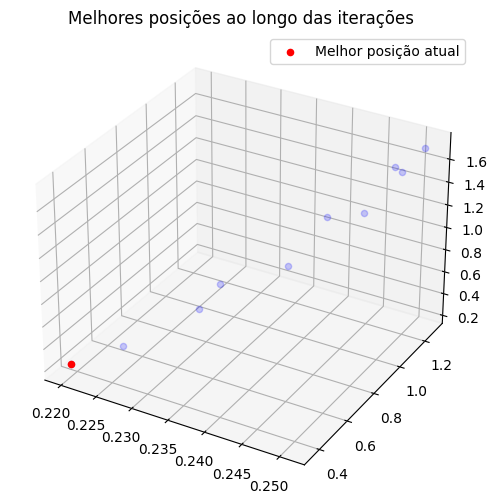

                              
*************************************************************************
Número total de iterações: 10
Número de Particulas: 30
                              
Melhor custo: 0.0
Melhor custo pessoal (pbest) de cada partícula: 0.0


In [203]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])


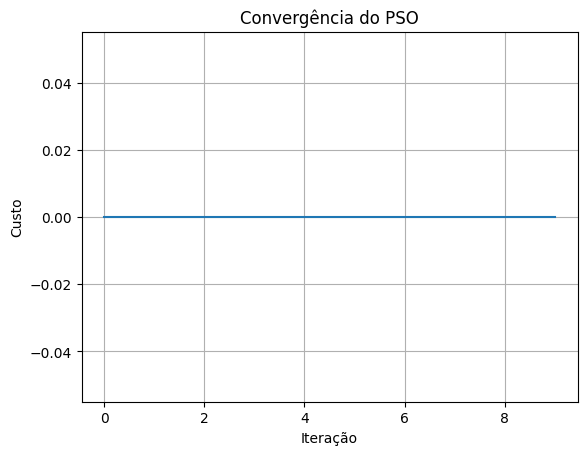

In [204]:
# Plotar o gráfico de convergência
plt.plot(range(max_iterations), cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Convergência do PSO')
plt.grid(True)
plt.show()